# YouTube Comments Sentiment Analysis 

In [1]:
# Basics
import pandas as pd
import os
import csv
import numpy as np
import re
import warnings
warnings.filterwarnings('ignore')

### Data Loading
Disini saya menggunakan data dari 5 komentar youtube video, 1 twitter, dan 1 sumber dari kaggle

In [2]:
# training data
#youtube coment
df1 = pd.read_csv('DATASET/ogvid.csv', delimiter=";", skiprows=2, encoding='latin-1', engine='python') # read in the data
df2 = pd.read_csv('DATASET/dtvid.csv', delimiter=",", skiprows=2, encoding='utf-8', error_bad_lines=False, engine='python')
df3 = pd.read_csv('DATASET/tsvid.csv', delimiter=",", skiprows=2, nrows=180, encoding='utf-8', engine='python')
df4 = pd.read_csv('DATASET/lgvid.csv', delimiter=",", skiprows=2, nrows=200, encoding='utf-8', engine='python')
df5 = pd.read_csv('DATASET/rwvid.csv', delimiter=",", skiprows=2, nrows=61, encoding='utf-8', engine='python')
#kaggle
df6 = pd.read_csv('DATASET/kaggel.csv', delimiter=",", skiprows=2, encoding='latin-1', engine='python') # read in the data
#twitter
df7 = pd.read_csv('DATASET/twt.csv', delimiter=",", skiprows=2, encoding='latin-1', engine='python') # read in the data

## Data Preprocessing

In [3]:
# clean dataframes
df7 = df7.drop(['Topic', 'TweetId', "TweetDate"], axis = 1).dropna()
df7.head()

,Sentiment,TweetText
0,positive,Now all @Apple has to do is get swype on the i...
1,positive,@Apple will be adding more carrier support to ...
2,positive,Hilarious @youtube video - guy does a duet wit...
3,positive,@RIM you made it too easy for me to switch to ...
4,positive,I just realized that the reason I got into twi...


In [4]:
def fix_cols(DF):
    DF = DF.iloc[:,:2]
    DF.columns = ["label", "comment"]
    return DF

In [5]:
df1 = fix_cols(df1)
df2 = fix_cols(df2)
df3 = fix_cols(df3)
df4 = fix_cols(df4)
df5 = fix_cols(df5)
df7 = fix_cols(df7)



df1.head()

,label,comment
0,-1.0,Everyone knows brand's papers from.\rBut -No o...
1,0.0,ÒYour paper cut balance is: \r-£25279102771Ó
2,1.0,OH SHIT WHEN I SAW THIS ON MY FRONT PAGE.........
3,1.0,Blowing my mind yet again
4,0.0,Should have gone with Dunder Mifflin


In [6]:
df7.label = df7.label.replace({'positive': '1.0', 'negative':'-1.0', 'neutral': '0.0', 'irrelevant': '0.0'}, regex=True)
df7['label'] = pd.to_numeric(df7['label'], errors='coerce')

In [7]:
df6 = fix_cols(df6)
df7 = fix_cols(df7)

df7.head()

,label,comment
0,1.0,Now all @Apple has to do is get swype on the i...
1,1.0,@Apple will be adding more carrier support to ...
2,1.0,Hilarious @youtube video - guy does a duet wit...
3,1.0,@RIM you made it too easy for me to switch to ...
4,1.0,I just realized that the reason I got into twi...


### Membuat Datasets

In [8]:
yt_comments = pd.concat([df1,df2,df3,df4,df5], ignore_index=True)
yt_comments.head()

,label,comment
0,-1.0,Everyone knows brand's papers from.\rBut -No o...
1,0.0,ÒYour paper cut balance is: \r-£25279102771Ó
2,1.0,OH SHIT WHEN I SAW THIS ON MY FRONT PAGE.........
3,1.0,Blowing my mind yet again
4,0.0,Should have gone with Dunder Mifflin


In [9]:
non_yt_comments = pd.concat([df6, df7], ignore_index=True)
non_yt_comments.head()

,label,comment
0,1.0,i liked the Da Vinci Code a lot
1,1.0,i liked the Da Vinci Code a lot
2,1.0,I liked the Da Vinci Code but it ultimatly di...
3,1.0,that's not even an exaggeration ) and at midn...
4,1.0,I loved the Da Vinci Code but now I want some...


In [10]:
comments = pd.concat([yt_comments, non_yt_comments], ignore_index=True)
comments.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17185 entries, 0 to 17184
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   label    14830 non-null  float64
 1   comment  17182 non-null  object 
dtypes: float64(1), object(1)
memory usage: 268.6+ KB


### Menghapus Kata Non-Alphabetic 

In [11]:
def convert_to_string(DF):
    DF["comment"]= DF["comment"].astype(str) 

In [12]:
convert_to_string(comments)

In [13]:
def cleanerFn(b):
    # hanya menyimpan kata-kata dengan karakter alfabet di komentar
    for row in range(len(b)):
        line = b.loc[row, "comment"]
        b.loc[row,"comment"] = re.sub("[^a-zA-Z]", " ", line)

In [14]:
cleanerFn(comments)
comments.head()

,label,comment
0,-1.0,Everyone knows brand s papers from But No on...
1,0.0,Your paper cut balance is
2,1.0,OH SHIT WHEN I SAW THIS ON MY FRONT PAGE ...
3,1.0,Blowing my mind yet again
4,0.0,Should have gone with Dunder Mifflin


### Natural Language Processing

In [15]:
import nltk
from nltk.tokenize import sent_tokenize, word_tokenize
from nltk.corpus import stopwords
from nltk.stem.porter import *
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer

In [16]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to C:\Users\ASUS
[nltk_data]     TUF\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [17]:
nltk.download('wordnet')


[nltk_data] Downloading package wordnet to C:\Users\ASUS
[nltk_data]     TUF\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [18]:
sw = stopwords.words('english')
ps = PorterStemmer()
lemmatizer = nltk.stem.WordNetLemmatizer()

#### Tokenization, Remove Stop Words, Lemmatization & Stemming

In [19]:
def nlpFunction(DF):
    DF['com_token'] = DF['comment'].str.lower().str.split()
    DF['com_remv'] = DF['com_token'].apply(lambda x: [y for y in x if y not in sw])
    DF["com_lemma"] = DF['com_remv'].apply(lambda x : [lemmatizer.lemmatize(y) for y in x]) # lemmatization
    DF['com_stem'] = DF['com_lemma'].apply(lambda x : [ps.stem(y) for y in x]) # stemming
    DF["com_tok_str"] = DF["com_stem"].apply(', '.join)
    DF["com_full"] = DF["com_remv"].apply(' '.join)
    return DF

In [20]:
comments = nlpFunction(comments)
comments.head()

,label,comment,com_token,com_remv,com_lemma,com_stem,com_tok_str,com_full
0,-1.0,Everyone knows brand s papers from But No on...,"[everyone, knows, brand, s, papers, from, but,...","[everyone, knows, brand, papers, one, knows, w...","[everyone, know, brand, paper, one, know, welf...","[everyon, know, brand, paper, one, know, welfa...","everyon, know, brand, paper, one, know, welfar...",everyone knows brand papers one knows welfare ...
1,0.0,Your paper cut balance is,"[your, paper, cut, balance, is]","[paper, cut, balance]","[paper, cut, balance]","[paper, cut, balanc]","paper, cut, balanc",paper cut balance
2,1.0,OH SHIT WHEN I SAW THIS ON MY FRONT PAGE ...,"[oh, shit, when, i, saw, this, on, my, front, ...","[oh, shit, saw, front, page, love, song]","[oh, shit, saw, front, page, love, song]","[oh, shit, saw, front, page, love, song]","oh, shit, saw, front, page, love, song",oh shit saw front page love song
3,1.0,Blowing my mind yet again,"[blowing, my, mind, yet, again]","[blowing, mind, yet]","[blowing, mind, yet]","[blow, mind, yet]","blow, mind, yet",blowing mind yet
4,0.0,Should have gone with Dunder Mifflin,"[should, have, gone, with, dunder, mifflin]","[gone, dunder, mifflin]","[gone, dunder, mifflin]","[gone, dunder, mifflin]","gone, dunder, mifflin",gone dunder mifflin


In [21]:
def drop_cols_after_nlp(comments):
    comments = comments.drop(columns = ['comment', 'com_token', 'com_remv', 'com_lemma', 'com_stem', 'com_tok_str'], axis = 1)
    return comments
comments = drop_cols_after_nlp(comments)
comments.head()

,label,com_full
0,-1.0,everyone knows brand papers one knows welfare ...
1,0.0,paper cut balance
2,1.0,oh shit saw front page love song
3,1.0,blowing mind yet
4,0.0,gone dunder mifflin


In [22]:
comments.rename(columns = {'com_full': 'comment'}, inplace=True)
comments.head()

,label,comment
0,-1.0,everyone knows brand papers one knows welfare ...
1,0.0,paper cut balance
2,1.0,oh shit saw front page love song
3,1.0,blowing mind yet
4,0.0,gone dunder mifflin


In [23]:
def remove_missing_vals(comments): 
    comments['comment'] = comments['comment'].str.strip()
    comments = comments[comments.comment != 'nan'] # remove nan values from data
    comments = comments[comments.comment != '']
    
remove_missing_vals(comments)

In [24]:
comments.head()

,label,comment
0,-1.0,everyone knows brand papers one knows welfare ...
1,0.0,paper cut balance
2,1.0,oh shit saw front page love song
3,1.0,blowing mind yet
4,0.0,gone dunder mifflin


In [25]:
comments['label'].isna().sum()

2355

In [26]:
comments = comments[comments['label'].notna()]
comments['label'].isna().sum()

0

In [27]:
len(comments)

14830

In [28]:
X = comments['comment']
y = comments.label

In [29]:
# split X and y into training and testing sets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=32, test_size=0.20)

In [30]:
# Initialize count vectorizer
count_vectorizer = CountVectorizer(stop_words='english', 
                                   min_df=0.05, max_df=0.9)

# Create count train and test variables
count_train = count_vectorizer.fit_transform(X_train)
count_test = count_vectorizer.transform(X_test)

# Initialize tfidf vectorizer
tfidf_vectorizer = TfidfVectorizer(stop_words='english', 
                                   min_df=0.05, max_df=0.9)

# Create tfidf train and test variables
tfidf_train = tfidf_vectorizer.fit_transform(X_train)
tfidf_test = tfidf_vectorizer.transform(X_test)

## Model Building

In [31]:
# Set seed for reproducibility
import random; random.seed(5)

# Import all we need from sklearn
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn import metrics

### Naive-Bayes Model


In [32]:
# Create Nb Model
tfidf_nb = MultinomialNB()
tfidf_nb.fit(tfidf_train,y_train)
# Run predict on your TF-IDF test data to get your predictions
tfidf_nb_pred = tfidf_nb.predict(tfidf_test)

# Calculate the accuracy of your predictions
tfidf_nb_score = metrics.accuracy_score(y_test,tfidf_nb_pred)

# Create a MulitnomialNB model
count_nb = MultinomialNB()
count_nb.fit(count_train,y_train)


count_nb_pred = count_nb.predict(count_test)


count_nb_score = metrics.accuracy_score(count_nb_pred,y_test)

print('NaiveBayes Tfidf Score: ', tfidf_nb_score)
print('NaiveBayes Count Score: ', count_nb_score)

NaiveBayes Tfidf Score:  0.7872555630478759
NaiveBayes Count Score:  0.7805124747134188


### Logistic Regression Model


from sklearn.linear_model import LogisticRegression
lr_model_tfidf = LogisticRegression()
lr_model_tfidf.fit(tfidf_train,y_train)
accuracy_lr_tfidf= lr_model_tfidf.score(tfidf_test,y_test)
print("Logistic Regression Tf Idf Accuracy) :",accuracy_lr_tfidf)

In [34]:
lr_model = LogisticRegression()
lr_model.fit(count_train,y_train)
accuracy_lr = lr_model.score(count_test,y_test)
print("Logistic Regression accuracy :",accuracy_lr)

Logistic Regression accuracy : 0.7875927174645988


### SVM Model

In [35]:
# Create a SVM model
from sklearn import svm
tfidf_svc = svm.SVC(kernel='linear', C=1)

tfidf_svc.fit(tfidf_train,y_train)

tfidf_svc_pred = tfidf_svc.predict(tfidf_test)

tfidf_svc_score = metrics.accuracy_score(y_test,tfidf_svc_pred)

print("LinearSVC Score (for tfidf):   %0.3f" % tfidf_svc_score)

LinearSVC Score (for tfidf):   0.794


In [36]:
count_svc = svm.SVC(kernel='linear', C=1)

count_svc.fit(count_train,y_train)

count_svc_pred = count_svc.predict(count_test)


count_svc_score = metrics.accuracy_score(y_test,count_svc_pred)

print("LinearSVC Score (for Count):   %0.3f" % tfidf_svc_score)

LinearSVC Score (for Count):   0.794


### Desicion Tree Model

In [37]:
from sklearn.tree import DecisionTreeClassifier
dt_model_tfidf = DecisionTreeClassifier()
dt_model_tfidf.fit(tfidf_train,y_train)
accuracy_dt_tfidf = dt_model_tfidf.score(tfidf_test,y_test)
print("Decision Tree accuracy is (for Tfidf):",accuracy_dt_tfidf)

Decision Tree accuracy is (for Tfidf): 0.8017532029669588


In [38]:
dt_model = DecisionTreeClassifier()
dt_model.fit(count_train,y_train)
accuracy_dt = dt_model.score(count_test,y_test)
print("Decision Tree accuracy is (for Count):",accuracy_dt)

Decision Tree accuracy is (for Count): 0.8017532029669588


### Random Forest Model

In [39]:
from sklearn.ensemble import RandomForestClassifier
rf_model_tfidf = RandomForestClassifier(n_estimators = 5, random_state = 1)
rf_model_tfidf.fit(tfidf_train,y_train)
accuracy_rf_tfidf = rf_model_tfidf.score(tfidf_test,y_test)
print("Random Forest accuracy for 5 trees is (Tfidf):",rf_model_tfidf.score(tfidf_test,y_test))

Random Forest accuracy for 5 trees is (Tfidf): 0.8020903573836817


In [40]:
rf_model= RandomForestClassifier(n_estimators = 5, random_state = 1)
rf_model.fit(count_train,y_train)
accuracy_rf_count = rf_model.score(count_test,y_test)
print("Random Forest accuracy for 5 trees is (Count):",rf_model.score(count_test,y_test))

Random Forest accuracy for 5 trees is (Count): 0.8027646662171275


Akurasi Tertinggi Di dapatkan Menggunakan Random Forest

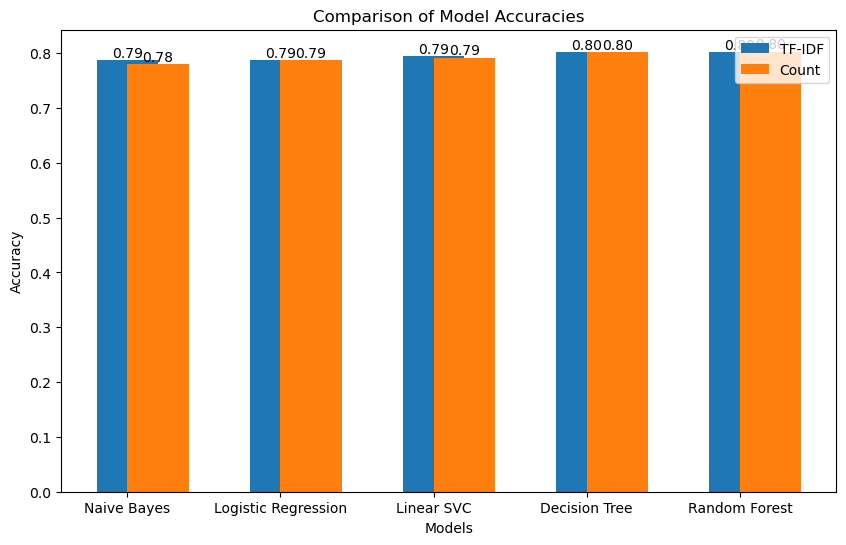

In [41]:
import matplotlib.pyplot as plt
# Membuat data untuk visualisasi
models = ['Naive Bayes', 'Logistic Regression', 'Linear SVC', 'Decision Tree', 'Random Forest']
tfidf_scores = [tfidf_nb_score, accuracy_lr_tfidf, tfidf_svc_score, accuracy_dt_tfidf, accuracy_rf_tfidf]
count_scores = [count_nb_score, accuracy_lr, count_svc_score, accuracy_dt, accuracy_rf_count]

# Membuat bar plot
x = range(len(models))
plt.figure(figsize=(10, 6))
bar1 = plt.bar(x, tfidf_scores, width=0.4, label='TF-IDF', align='center')
bar2 = plt.bar(x, count_scores, width=0.4, label='Count', align='edge')

# Menambahkan jumlah nilai di atas batang
def add_value_labels(bars):
    for bar in bars:
        height = bar.get_height()
        plt.text(bar.get_x() + bar.get_width() / 2, height, f'{height:.2f}', ha='center', va='bottom')

add_value_labels(bar1)
add_value_labels(bar2)

plt.xlabel('Models')
plt.ylabel('Accuracy')
plt.title('Comparison of Model Accuracies')
plt.xticks(x, models)
plt.legend()
plt.show()



Dalam plot perbandingan yang telah saya buat, saya menggunakan dua warna berbeda untuk membedakan antara dua metode vektorisasi teks yang saya gunakan:

- **Warna Biru**: Batang berwarna biru dalam plot mewakili akurasi model saya menggunakan metode **TF-IDF (Term Frequency-Inverse Document Frequency) Vectorization**. Dalam metode ini, saya mengukur seberapa penting sebuah kata dalam dokumen di seluruh kumpulan data saya. Kata-kata yang sering muncul dalam satu dokumen tetapi jarang di seluruh dokumen lainnya mendapatkan skor lebih tinggi, yang menandakan pentingnya kata tersebut dalam konteks dokumen tersebut.

- **Warna Orange**: Batang berwarna orange mewakili akurasi model saya dengan menggunakan metode **Count Vectorization** yang biasa. Metode ini mengubah teks menjadi vektor berdasarkan seberapa sering kata muncul dalam dokumen. Saya menghitung frekuensi kemunculan setiap kata dan membuat representasi numerik berdasarkan jumlah ini.

Grafik ini sangat membantu saya untuk membandingkan efektivitas kedua metode vektorisasi teks ini dalam konteks berbagai  mesin. Dengan menampilkan akurasi kedua metode secara berdampingan untuk setiap model, saya dapat dengan mudah mengevaluasi mana metode yang lebih efektif untuk tugas analisis teks tertentu yang saya kerjakan.

# Prediksi Sentiment Analisyst Komentar 

In [42]:
prediction_comments = pd.read_csv('DATASET/bts.csv', delimiter=",", encoding='utf-8', engine='python')
prediction_comments = prediction_comments.iloc[:,:1]
prediction_comments.columns=['comment']
prediction_comments.head()

,comment
0,♪ Listen on Spotify!: https://spoti.fi/3gC9GfA...
1,My ears: *relaxing* My hands: *writing* My le...
2,Parents: You have to make us proud Partner: Y...
3,Little boy: “Are you an angel?” Girl: “What?”...
4,Reasons to live: “Suicide doesn’t stop the ...


In [43]:
prediction_comments.head()

,comment
0,♪ Listen on Spotify!: https://spoti.fi/3gC9GfA...
1,My ears: *relaxing* My hands: *writing* My le...
2,Parents: You have to make us proud Partner: Y...
3,Little boy: “Are you an angel?” Girl: “What?”...
4,Reasons to live: “Suicide doesn’t stop the ...


In [44]:
len(prediction_comments['comment'])

28291

In [45]:
convert_to_string(prediction_comments)
cleanerFn(prediction_comments)
prediction_comments = nlpFunction(prediction_comments)
prediction_comments = drop_cols_after_nlp(prediction_comments)
prediction_comments.rename(columns = {'com_full': 'comment'}, inplace=True)
remove_missing_vals(prediction_comments)
prediction_comments.head()

,comment
0,listen spotify https spoti fi gc gfa sheet mus...
1,ears relaxing hands writing legs dancing mouth...
2,parents make us proud partner pretty friends f...
3,little boy angel girl little boy mom told mark...
4,reasons live suicide stop pain gives someone e...


In [46]:
tfidf_pred = tfidf_vectorizer.transform(prediction_comments['comment'])
tfidf_rf_pred = rf_model_tfidf.predict(tfidf_pred)

In [47]:
neutral = (tfidf_nb_pred == 0.0).sum()
positive = (tfidf_nb_pred == 1.0).sum()
negative = (tfidf_nb_pred < 0).sum()

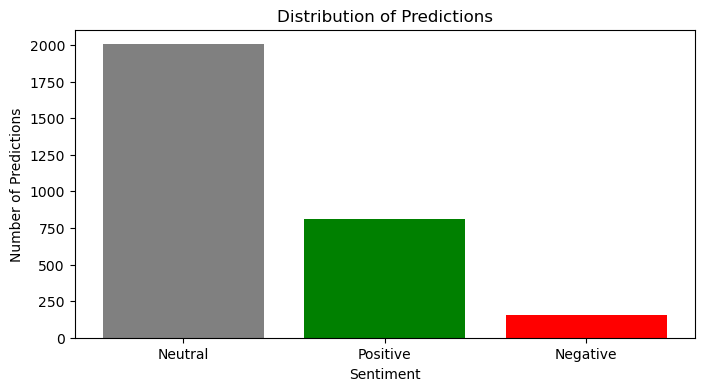

In [48]:
import matplotlib.pyplot as plt
# Membuat data untuk visualisasi
categories = ['Neutral', 'Positive', 'Negative']
values = [neutral, positive, negative]

# Membuat bar plot
plt.figure(figsize=(8, 4))
plt.bar(categories, values, color=['gray', 'green', 'red'])
plt.title('Distribution of Predictions')
plt.xlabel('Sentiment')
plt.ylabel('Number of Predictions')
plt.show()

In [49]:
print("Good video" if positive > negative else "Bad video")

Good video
